# Discriminatively Trained Bayesian Decoding

## Notation

| Variable |     Range     |  Description |
|----------|:-------------:|:------|
| $z_t$  | $[K] $ |  instantaneous discrete latent state |
| $x_t$  | $\mathbb{R}^D$ | instantaneous continuous latent state |
| $y_t$  | $\mathbb{R}^P$ | instantaneous behavior observation (video frame) |
| $n_t$  | $\mathbb{R}^N$ |instantaneous neural observation 

When I leave out the subscript, I'm referring to the entire time series of variables; e.g. $n = \{n_1, \ldots, n_T\}$.

## Model

$$
\begin{align}
p(z, x, y, n) &= p(z) \, p(x \mid z) \, p(y \mid x) \, p(n \mid x, z) \\
&= \prod_{t=1}^N p(z_t \mid z_{t-1}) \, p(x_t \mid z_t, x_{t-1}) \, p(y_t \mid x_t) \, p(n_t \mid x_t, z_t) \\
&= \prod_{t=1}^N \mathrm{Cat}(z_t \mid z_{t-1}) \, 
                 \mathcal{N}(x_t \mid A_{z_t}  x_{t-1} + b_{z_t}, Q_{z_t}) \, 
                 \mathcal{N}(y_t \mid \mu(x_t), \Sigma(x_t)) \, 
                 p(n_t \mid x_t, z_t).
\end{align}
$$
I'm leaving the conditional distribution of neural activity intentionally vague.  We're not going to fit it directly.  Instead, we'll try to just learn the inverse model.

## Goal

Compute $p(y \mid n)$.  From our model above,

$$
\begin{align}
p(y \mid n) &= \int p(y, x, z \mid n) \, \mathrm{d} x \, \mathrm{d} z\\
&= \int p(y \mid x, z, n) \, p(x, z \mid n)  \, \mathrm{d} x \, \mathrm{d} z \\
&= \int p(y \mid x) \, p(x, z \mid n)  \, \mathrm{d} x \, \mathrm{d} z,
\end{align}
$$
since $y \perp z, n \mid x$.  Assume we already have $p(y \mid x)$ and $p(x, z)$.  The remaining challenge is to compute the posterior $p(x, z \mid n)$.

## Approach

We come up with a procedure to approximately sample the posterior $p(x, z \mid n)$.  First, use the chain rule to break this into two steps,

$$
p(x, z \mid n) = p(z \mid n) \, p(x \mid z, n).
$$

First we decode the discrete state sequence $z$ given the observed neural activity; then we sample the continuous latent states $x$ given the neural activity and the decoded discrete states.  

The posterior distribution over the discrete states is,

$$
\begin{align*}
p(z \mid n) &\propto p(z, n) \\
&= p(z) p(n \mid z) \\
&= \left[\prod_{t=1}^T p(z_t \mid z_{t-1}) \right] p(n \mid z) \\
&= \prod_{t=1}^T p(z_t \mid z_{t-1}) \, p(n_t \mid z_{1:t}, n_{1:t-1}).
\end{align*}
$$
Unlike a standard HMM, the likelihoods depend on the whole history of past states because,
$$
p(n_t \mid z_{1:t}, n_{1:t-1}) = \int p(n_t \mid x_t) \, p(x_t \mid z_{1:t}, n_{1:t-1}) \, \mathrm{d} x_t \\
%  = \int p(n_t \mid x_t) \, p(x_{1:t} \mid z_{1:t}, n_{1:t-1}) \, \mathrm{d} x_{1:t} \\
$$

## Can we still work with this?

Here's the approach from the discriminative KF paper, which had Markovian likelihoods.
$$
\begin{align}
p(n_t \mid z_t) &= \frac{p(n_t, z_t)}{p(z_t)} \\
&= \frac{p(z_t \mid n_t) p(n_t)}{p(z_t)} \\
&\propto \frac{p(z_t \mid n_t)}{p(z_t)} \\
&\approx \frac{q(z_t \mid n_t)}{p_{\infty}(z_t)}
\end{align}
$$

where $p_\infty$ is the stationary distribution.

We have this instead,
$$
\begin{align}
p(n_t \mid z_{1:t}, n_{1:t-1}) &= \frac{p(n_t, z_{1:t} \mid n_{1:t-1})}{p(z_{1:t} \mid n_{1:t-1})} \\
&= \frac{p(z_{1:t} \mid n_{1:t}) p(n_t \mid n_{1:t-1})}{p(z_{1:t} \mid n_{1:t-1})} \\
&\propto \frac{p(z_{1:t} \mid n_{1:t})}{p(z_{1:t} \mid n_{1:t-1})} \\
&\approx \frac{q(z_{1:t} \mid n_{1:t})}{p(z_{1:t} \mid n_{1:t-1})}
\end{align}
$$

Maybe there is a way to learn these distributions, but it seems hard.  Or maybe there's a way to simplify?  Even if we did, I don't see how to plug them into a message passing routine to sample $p(z | n)$

## Go back to the original proposal

Let $v_t = (z_t, x_t)$.  Now
$$
\begin{align*}
p(n_t \mid v_t) &= \frac{p(n_t, v_t)}{p(v_t)} \\
&= \frac{p(v_t \mid n_t) p(n_t)}{p(v_t)} \\
&\propto \frac{p(v_t \mid n_t)}{p(v_t)} \\
&\approx \frac{q(v_t \mid n_t)}{p_{\infty}(v_t)}
\end{align*}
$$

For convenience, assume $q(v_t \mid n_t) = q(z_t \mid n_t) \, q(x_t \mid n_t)$

The stationary distribution $p_\infty (v_t) = p_\infty(z_t) \, p_\infty(x_t \mid z_t)$.
The stationary distribution of $z_t$ is an eigenvector of the transition matrix. The question is how to approximate $p_{\infty}(x_t \mid z_t)$.  We could just simulate long runs and compute the empirical distribution.

We still have to perform inference for the unnormalized model,
$$
p(z, x) \propto \prod_{t=1}^T p(z_t \mid z_{t-1}) \, p(x_t \mid z_{t}, x_{t-1}) \, \frac{q(z_t \mid n_t)}{p_\infty(z_t)} \, \frac{q(x_t \mid n_t)}{p_\infty(x_t \mid z_t)}
$$



# Plan

1. Train the "recognition network" to output $q(z_t \mid n_t)$ and $q(x_t \mid n_t)$. 

2. Compute $p_\infty(z_t)$ and $p_\infty(x_t \mid z_t)$

3. Write Gibbs sampler to target $p(z, x)$ defined above

  a. Sample $p(z \mid x) \propto \prod_{t=1}^T p(z_t \mid z_{t-1}) \, p(x_t \mid z_{t}, x_{t-1}) \, \frac{q(z_t \mid n_t)}{p_\infty(z_t)} = \prod_{t=1}^T p(z_t \mid z_{t-1}) \phi(z_t; x_t, n_t)$ 
  
  b. Sample $p(x \mid z) \propto \prod_{t=1}^T p(x_t \mid z_{t}, x_{t-1}) \, \frac{q(x_t \mid n_t)}{p_\infty(x_t \mid z_t)}  = \prod_{t=1}^T \mathcal{N}(x_t \mid A_{z_{t}} x_{t-1} + b_{z_t}, Q_{z_t}) \, \mathcal{N}(x_t; \mu(z_t, n_t), \Sigma(z_t, n_t))$

## Simulate synthetic data

In [1]:
import numpy as np
import numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
K = 2   # discrete states
D = 2   # continuous dim 
N = 3   # num neurons

eps = 0.99
P = eps * np.eye(K) + (1 - eps) * (1 - np.eye(K))

mu0 = np.zeros(D)
Sigma0 = np.eye(D)

A1 = 0.99 * np.eye(D)
theta = 0.1
A2 = np.array([[np.cos(theta),   np.sin(theta)],
               [-np.sin(theta),  np.cos(theta)]])
# A2 = 0.99 * np.eye(D)
As = np.array([A1, A2])

b1 = np.zeros(D)
b2 = 1 * np.ones(D)
bs = np.array([b1, b2])

Q1 = 0.1 * np.eye(D)
Q2 = 0.1 * np.eye(D)
Qs = np.array([Q1, Q2])


C = npr.randn(N, D)
d = np.zeros(N)
# Try a nonlinear emission model 
# f = lambda xs: xs @ C.T + d 
sigmoid = lambda x: 1 / (1 + np.exp(-x))
f = lambda xs: sigmoid((xs @ C.T + d) / 15)
S = 0.01 * np.eye(N)

In [3]:
# Simulate some data
T = 3000

zs = np.zeros(T, dtype=int)
xs = np.zeros((T, D))
ns = np.zeros((T, N))

# Initialize
zs[0] = 0
xs[0] = npr.multivariate_normal(mu0, Sigma0)

for t in np.arange(1, T):
    # Sample z_t | z_{t-1}
    zs[t] = npr.choice(K, p=P[zs[t-1]])
    # Sample x_t | x_{t-1}, z_t
    xs[t] = npr.multivariate_normal(As[zs[t]] @ xs[t-1] + bs[zs[t]], Qs[zs[t]])

# Sample n_t | x_T
ns = f(xs) + npr.multivariate_normal(np.zeros(N), S, size=(T))

(0, 1)

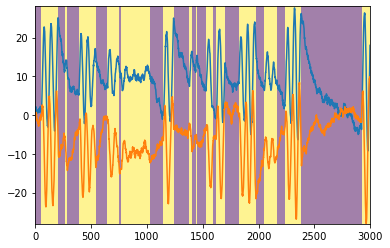

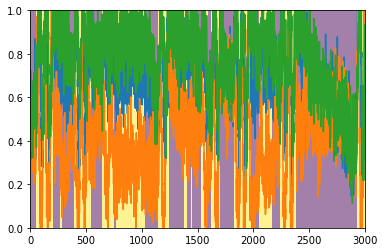

In [4]:
xlim = abs(xs).max()
nlim = abs(ns).max()

plt.figure()
plt.imshow(zs[None, :], aspect="auto", extent=(0, T, -xlim, xlim), alpha=0.5)
plt.plot(xs)
plt.xlim(0, T)
plt.ylim(-xlim, xlim)

plt.figure()
# plt.imshow(zs[None, :], aspect="auto", extent=(0, T, -nlim, nlim), alpha=0.5)
plt.imshow(zs[None, :], aspect="auto", extent=(0, T, 0, 1), alpha=0.5)
plt.plot(ns)
plt.xlim(0, T)
plt.ylim(0, 1)

## Train the recognition networks

In [5]:
from sklearn.linear_model import LogisticRegression, LinearRegression

W = 10
ns_pad = np.concatenate([np.zeros((W//2, N)), ns, np.zeros((W//2, N))])
ns_window = np.column_stack([ns_pad[w:T+w] for w in range(W)] )

In [6]:
recog_z = LogisticRegression(solver="lbfgs")
recog_z.fit(ns_window, zs)
log_qz = recog_z.predict_log_proba(ns_window)

(0, 2000)

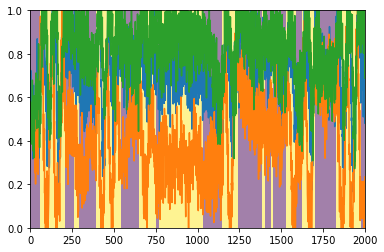

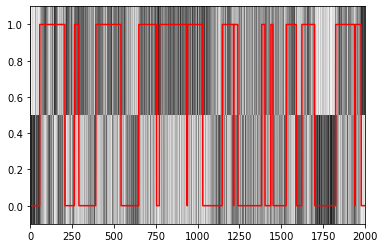

In [7]:

plt.figure()
plt.imshow(zs[None, :], aspect="auto", extent=(0, T, 0, 1), alpha=0.5)
plt.plot(ns)
plt.xlim(0, 2000)
plt.ylim(0, 1)

plt.figure()
plt.imshow(np.exp(log_qz).T, aspect="auto", cmap="Greys")
plt.plot(zs, '-r')
plt.ylim(-0.1, 1.1)
plt.xlim([0, 2000])
# plt.colorbar()

In [8]:
# Train a linear regression 
recog_x = LinearRegression()
recog_x.fit(ns_window, xs)
q_mu_x = recog_x.predict(ns_window)
q_Sigma_x = np.cov((xs - q_mu_x).T)

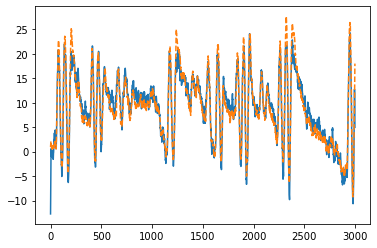

In [9]:
plt.plot(q_mu_x[:, 0])
plt.plot(xs[:, 0], '--')

## Compute the stationary distribution

In [10]:
evals, evecs = np.linalg.eig(P.T)
perm = np.argsort(evals)[::-1]
evals, evecs = evals[perm], evecs[:, perm]
assert np.allclose(evals[0], 1.0)
assert np.all(evecs[:,0] >= 0)
pz_infty = evecs[:, 0] / evecs[:, 0].sum()

In [11]:
mu_infty = np.zeros((K, D))
Sigma_infty = np.zeros((K, D, D))
for k in range(K):
    mu_infty[k] = np.mean(xs[zs == k])
    Sigma_infty[k] = np.cov(xs[zs == k].T)
    
# TODO Check that q_Sigma_x

## Decode the discrete states with a regular HMM

In [12]:
# Compute the observation potentials, log q(z; n) - log p_infty(z)
z_potential = log_qz - np.log(pz_infty)

# Plug these into the HMM smoother
from ssm.primitives import hmm_expected_states, hmm_sample
z_posterior, _, _ = hmm_expected_states(np.log(pz_infty), np.log(P)[None, :, :], z_potential)
z_sample = hmm_sample(np.log(pz_infty), np.log(P)[None, :, :], z_potential)

(0, 3000)

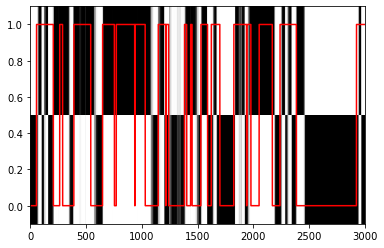

In [13]:
plt.figure()
plt.imshow(z_posterior.T, aspect="auto", cmap="Greys")
plt.plot(zs, '-r')
# plt.plot(z_sample, '--b')
plt.ylim(-0.1, 1.1)
plt.xlim([0, 3000])

## Decode the continuous states given a sample of the discrete states

$$\frac{q(x_t \mid n_t)}{p_\infty(x_t \mid z_t)} 
= \frac{\mathcal{N}(\mu(n_t), \Sigma(n_t))}{\mathcal{N}(\mu_{\infty}(z_t), \Sigma_\infty(z_t))}
\propto \exp \left\{ -\frac{1}{2} x_t^\top [\Sigma(n_t)^{-1} - \Sigma_\infty(z_t)^{-1}] x_t 
 + x_t^\top [\Sigma(n_t)^{-1} \mu(n_t) - \Sigma_\infty(z_t)^{-1} \mu_\infty(z_t)]\right\}
$$

Completing the square, this is proportional to a Gaussian with covariance

$$
\tilde{\Sigma}_t = [\Sigma(n_t)^{-1} - \Sigma_\infty(z_t)^{-1}]^{-1}
$$
and mean
$$
\tilde{\mu}_t = \tilde{\Sigma} [\Sigma(n_t)^{-1} \mu(n_t) - \Sigma_\infty(z_t)^{-1} \mu_\infty(z_t)]
$$

We plug this into a Kalman filter with emission matrix $C = I$, emission covariance $\tilde{\Sigma}_t$, and observation $\tilde{\mu}_t$

For this to be valid, the precision of the recognition network has to be larger than the stationary precision.  I.e. conditioning on data has to provide more certainty than simply assuming stationarity.

In [14]:
Sigma_tildes = np.linalg.inv(np.linalg.inv(q_Sigma_x) - np.linalg.inv(Sigma_infty))
assert np.all(np.linalg.eigvals(Sigma_tildes) > 0)
Sigma_tildes = Sigma_tildes[z_sample]

h_recog = np.linalg.solve(q_Sigma_x, q_mu_x.T).T
h_infty = np.linalg.solve(Sigma_infty, mu_infty)[z_sample]
mu_tildes = np.einsum('tij, tj -> ti', Sigma_tildes, h_recog + h_infty)

inputs = np.ones((T, 1))

# from ssm.messages_numba import kalman_sample
from pylds.lds_messages_interface import filter_and_sample
_, x_sample = filter_and_sample(
    mu0, Sigma0,                                            # initial distribution
    As[z_sample], bs[z_sample, :, None], Qs[z_sample],      # dynamics
    np.tile(np.eye(D)[None, :, :], (T, 1, 1)),              # pseudo-emission matrix
    np.zeros((T, D, 1)),                                    # pseudo-emission bias
    Sigma_tildes,                                           # pseudo-emission covariance
    inputs,                                                 # inputs (all ones)
    mu_tildes                                               # pseudo-emissions
)

In [15]:
from pylds.lds_messages_interface import rts_smoother
_, x_bayes, _ = rts_smoother(
    mu0, Sigma0,                                            # initial distribution
    As[z_sample], bs[z_sample, :, None], Qs[z_sample],      # dynamics
    np.tile(np.eye(D)[None, :, :], (T, 1, 1)),              # pseudo-emission matrix
    np.zeros((T, D, 1)),                                    # pseudo-emission bias
    Sigma_tildes,                                           # pseudo-emission covariance
    inputs,                                                 # inputs (all ones)
    mu_tildes                                               # pseudo-emissions
)

In [16]:
# Use the information form.  It will generalize better to VI.
from pylds.lds_messages_interface import info_E_step

# Compute the info potentials for the initial condition
def _info_params(mu0, Sigma0, As, bs, Qs, q_mu_x, q_Sigma_x, Sigma_infty, mu_infty, Ez):
    # parameter checking
    T, K = Ez.shape
    assert As.shape[0] == K and As.ndim == 3 and As.shape[1] == As.shape[2]
    D = As.shape[1]
    assert mu0.shape == (D,)
    assert Sigma0.shape == (D, D)
    assert bs.shape == (K, D)
    assert Qs.shape == (K, D, D)
    assert q_mu_x.shape == (T, D)
    assert q_Sigma_x.shape == (D, D)
    
    # Make pseudo-inputs (all ones) for bias terms
    inputs = np.ones((T, 1))
    
    # Convert initial distribution to info form
    # (ignore normalizing constants)
    J0 = np.linalg.inv(Sigma0)
    h0 = J0 @ mu0
    log_Z0 = 0

    # Info dynamics parameters
    J_pair_22 = np.linalg.inv(Qs)
    J_pair_21 = -np.matmul(np.linalg.inv(Qs), As)
    J_pair_11 = np.matmul(np.swapaxes(As, 1, 2), -J_pair_21)
    mBTQiA = np.matmul(np.swapaxes(bs[:, :, None], 1, 2), J_pair_21)
    BTQi = np.matmul(np.swapaxes(bs[:, :, None], 1, 2), J_pair_22)

    # Get expected sufficient statistics by integrating over z
    J_pair_22 = np.einsum('tk, kij -> tij', Ez[:-1], J_pair_22)
    J_pair_21 = np.einsum('tk, kij -> tij', Ez[:-1], J_pair_21)
    J_pair_11 = np.einsum('tk, kij -> tij', Ez[:-1], J_pair_11)
    mBTQiA = np.einsum('tk, kij -> tij', Ez[:-1], mBTQiA)
    BTQi = np.einsum('tk, kij -> tij', Ez[:-1], BTQi)
    h_pair_1 = np.einsum('tu, tud -> td', inputs[:-1], mBTQiA)
    h_pair_2 = np.einsum('tu, tud -> td', inputs[:-1], BTQi)
    log_Z_pair = np.zeros(T-1)

    # Info emission parameters
    J_obs = (np.linalg.inv(q_Sigma_x) - np.linalg.inv(Sigma_infty))[z_sample]
    h_recog = np.linalg.solve(q_Sigma_x, q_mu_x.T).T
    h_infty = np.linalg.solve(Sigma_infty, mu_infty)[z_sample]
    h_obs = h_recog + h_infty
    log_Z_obs = np.zeros(T)
    
    return J0, h0, log_Z0, \
           J_pair_11, J_pair_21, J_pair_22, h_pair_1, h_pair_2, log_Z_pair, \
           J_obs, h_obs, log_Z_obs

onehot = lambda x, K: x[:, None] == np.arange(K) 
Ez = onehot(z_sample, K)

_, x_bayes_info, _, _ = info_E_step(
    *_info_params(mu0, Sigma0, As, bs, Qs, 
                  q_mu_x, q_Sigma_x, Sigma_infty, mu_infty, Ez)
)

assert np.allclose(x_bayes, x_bayes_info)

(0, 2000)

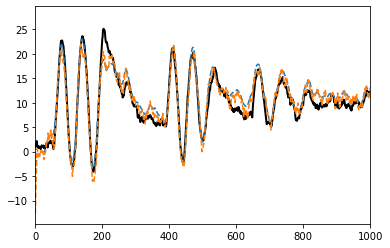

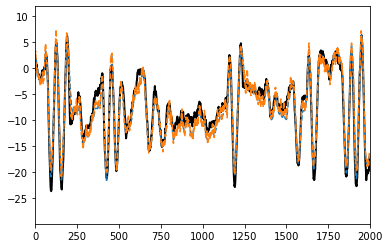

In [17]:
plt.figure()
plt.plot(xs[:, 0], '-k', lw=2)
plt.plot(x_bayes[:, 0], '--')
plt.plot(q_mu_x[:, 0], '--')
plt.xlim(0, 1000)

plt.figure()
plt.plot(xs[:, 1], '-k', lw=2)
plt.plot(x_bayes[:, 1], '--')
plt.plot(q_mu_x[:, 1], '--')
plt.xlim(0, 2000)

In [18]:
# Measure MSE
mse_raw = np.mean((q_mu_x - xs)**2)
print("MSE Raw decoder:   ", mse_raw)

mse_bayes = np.mean((x_bayes - xs)**2)
print("MSE Bayes decoder: ", mse_bayes)


MSE Raw decoder:    3.028238264938009
MSE Bayes decoder:  3.1643007340693137


## Run VI to see if we can improve this

In [19]:
n_iter = 100

from ssm.stats import multivariate_normal_logpdf

# Initialize q(z) with just the learned recognition potential
z_potential = log_qz - np.log(pz_infty)
Ez, _, _ = hmm_expected_states(np.log(pz_infty), np.log(P)[None, :, :], z_potential)

for i in range(n_iter):
    # compute the expected value of x given z and the observation potential
    _, Ex, _, _ = info_E_step(
        *_info_params(mu0, Sigma0, As, bs, Qs, 
                      q_mu_x, q_Sigma_x, Sigma_infty, mu_infty, Ez)
    )
    
    # Update z, now including the dynamics potential
    # TODO: Should really include the covariance of x in this update too
    z_dyn_potential = np.column_stack(
        [multivariate_normal_logpdf(Ex[1:], Ex[:-1] @ A.T + b, Q) 
         for A, b, Q in zip(As, bs, Qs)])
    z_dyn_potential = np.row_stack((np.zeros(K), z_dyn_potential))
    z_potential = log_qz - np.log(pz_infty) + z_dyn_potential
    Ez, _, _ = hmm_expected_states(np.log(pz_infty), np.log(P)[None, :, :], z_potential)

    print("MSE: ", np.mean((Ex - xs)**2))

MSE:  3.1831787491124537
MSE:  2.405296314590452
MSE:  2.3908837026135523
MSE:  2.387298159386921
MSE:  2.3881520592642063
MSE:  2.3908078677408957
MSE:  2.393432267354907
MSE:  2.3956346469573626
MSE:  2.3912341506994355
MSE:  2.3895818058583886
MSE:  2.389771583441548
MSE:  2.3947573413183614
MSE:  2.3999964435760974
MSE:  2.4009828275301675
MSE:  2.4079832950078317
MSE:  2.413252184955399
MSE:  2.416427568707827
MSE:  2.4177811423496234
MSE:  2.4159434605574073
MSE:  2.426580148354588
MSE:  2.426979257153242
MSE:  2.4268110754089665
MSE:  2.4237971447830455
MSE:  2.4174448882670827
MSE:  2.4171673444709274
MSE:  2.4159008600233736
MSE:  2.4156077012969335
MSE:  2.4166379787928776
MSE:  2.4152204740621555
MSE:  2.4200252199797325
MSE:  2.423013910488144
MSE:  2.427940646852501
MSE:  2.4267793917741054
MSE:  2.4161437364590523
MSE:  2.4120717494630792
MSE:  2.4120691428722707
MSE:  2.4121888687542796
MSE:  2.4121187236647983
MSE:  2.409548140950292
MSE:  2.41341226616685
MSE:  2.41625

(0, 3000)

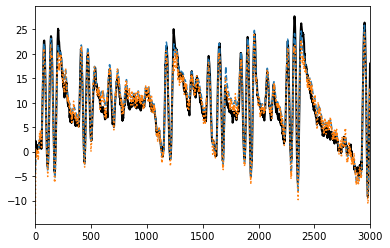

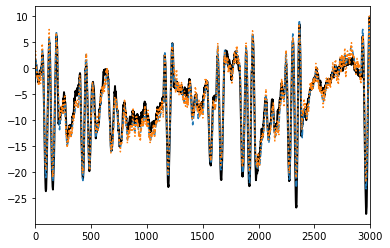

In [23]:
plt.figure()
plt.plot(xs[:, 0], '-k', lw=2)
plt.plot(Ex[:, 0], '--')
plt.plot(q_mu_x[:, 0], ':')
plt.xlim(0, 3000)

plt.figure()
plt.plot(xs[:, 1], '-k', lw=2)
plt.plot(Ex[:, 1], '--')
plt.plot(q_mu_x[:, 1], ':')
plt.xlim(0, 3000)